In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import json

In [2]:
from workspace import nometools as nome
from workspace import utils

In [3]:
main_path = Path('..')
data_path = main_path / 'Data'
steric_path = main_path / 'superposition' / 'clash_1KX5'
intersect_path = main_path / 'Data' / 'intersect_regions'
sliding_path = main_path / 'Data' / 'sliding_window_1kx5'

ref_path = data_path / 'GRCh38genome'
transcriptome_path = data_path / 'transcriptome'

#### Normalize Steric Clash

In [4]:
infile = steric_path / 'x_y_dict'
with open(infile, 'rb') as fin:
    x_y_clash_dict = pickle.load(fin)

x_y_clash_dict_norm_ = utils.normalize_clash_dict(x_y_clash_dict)

meth_thres_range = [0, 10, 20]
clash_thres_range = [5, 10, 20, 50]

params = []
for clash_thres in clash_thres_range:
    for meth_thres in meth_thres_range:
        k = "c" + str(clash_thres) + "m" + str(meth_thres)
        params.append(k)

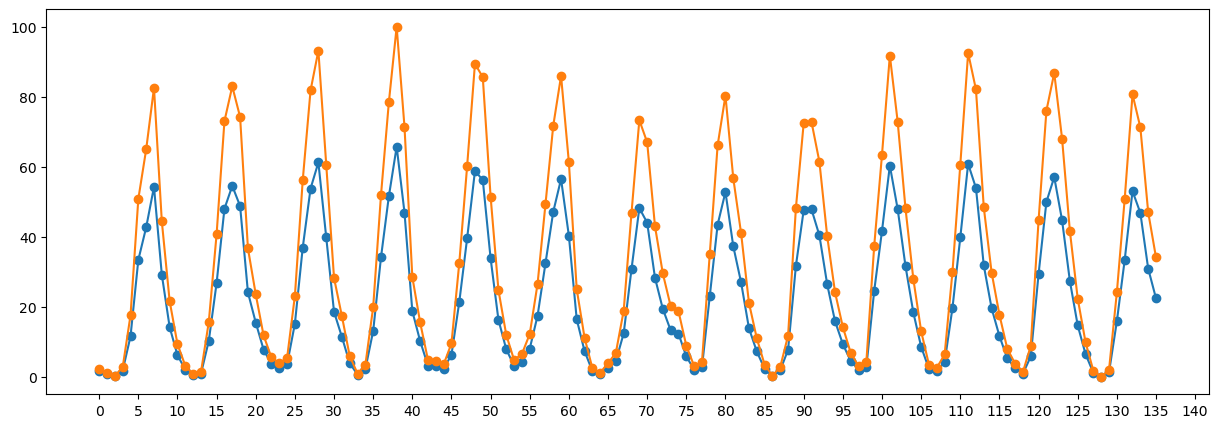

In [5]:
plt.figure(figsize=(15,5))
plt.plot(x_y_clash_dict.values(), marker='o')
plt.plot(x_y_clash_dict_norm_.values(), marker='o')
plt.xticks(range(0,len(x_y_clash_dict.values())+5,5))
plt.show()

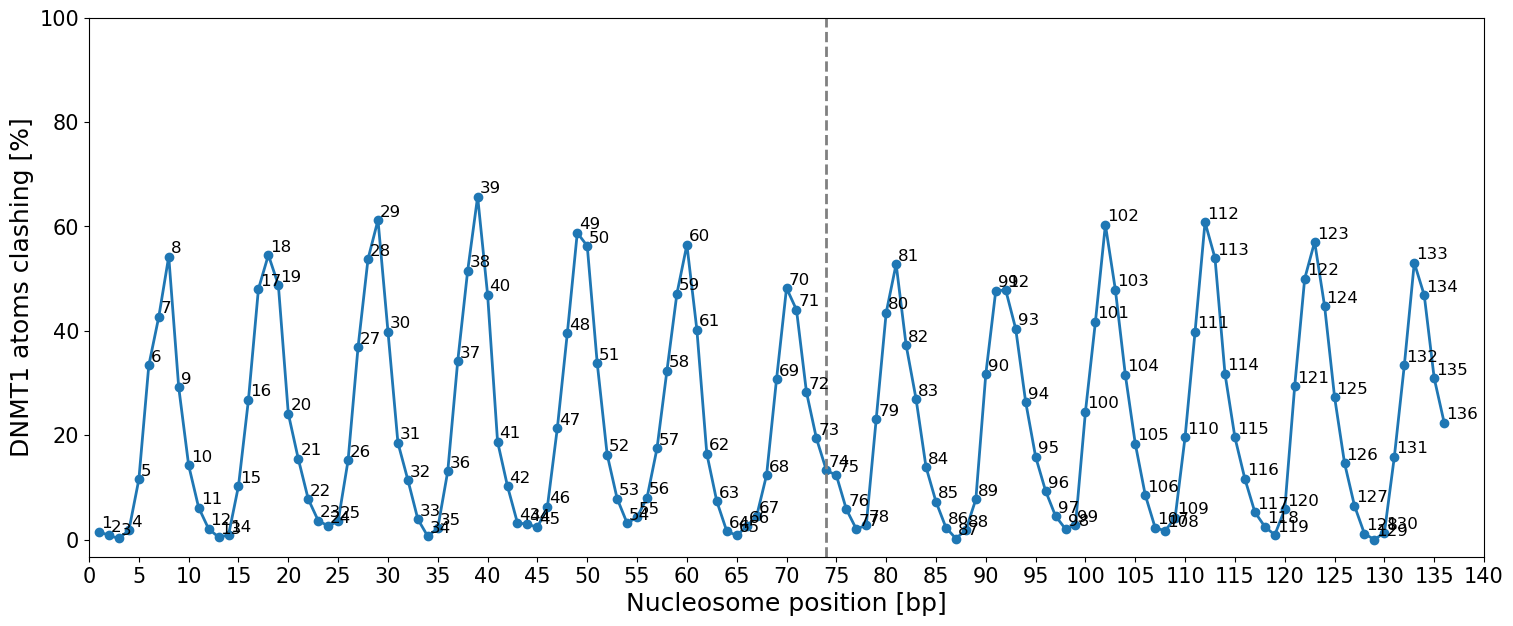

In [6]:
x = list(x_y_clash_dict.keys())
y = list(x_y_clash_dict.values())

fig = plt.figure(figsize=(18, 7))
ax = plt.subplot(111)

#plt.title('Superposition of DNMT1 (3PTA) and the nucleosome (1KX5)')
# print(sum(np.array(y) < 5))
ax.plot(x, y, linestyle="-", marker="o", linewidth=2)
# ax.plot(np.array(x)[np.array(y) < 5], np.array(y)[np.array(y) < 5], '*', color='red')
for pos in range(0,len(x)):
    #ax.text(x[pos]+0.3,y[pos],rmsd_list[pos])
    ax.text(x[pos]+0.2, y[pos]+0.7, x[pos], fontsize=12)
    
plt.xlim(0,140)
plt.xticks(range(0,len(x)+5,5), fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Nucleosome position [bp]", fontsize=18)
plt.ylabel("DNMT1 atoms clashing [%]", fontsize=18)
plt.ylim(top=100)

ax.axvline(x=74,c="grey",linewidth=2,linestyle="--")#4169e1

In [31]:
len(x_y_clash_dict.keys()), len(x_y_clash_dict_norm_.keys())

(136, 136)

#### Expression and Map

In [8]:
df_expression = pd.read_csv(transcriptome_path / 'LTC_HepG2_MonoCal_FA.rep1.TPM.txt', sep='\t', names=['id', 'expression'], header=0)
df_expression['gene_id'] = df_expression['id'].str.split(':').str[0]
df_expression.head()

,id,expression,gene_id
0,ENSG00000219391:AC019129.1,0.0,ENSG00000219391
1,ENSG00000224632:Z73361.1,0.0,ENSG00000224632
2,ENSG00000281691:RBM5-AS1,0.0,ENSG00000281691
3,ENSG00000222293:RNU2-36P,0.0,ENSG00000222293
4,ENSG00000283803:MIR3198-2,0.0,ENSG00000283803


In [ ]:
# df_expression = pd.read_csv(transcriptome_path / 'GSM2343347.tsv', sep='\t')
# df_expression.head()

In [9]:
with open(ref_path / 'transcript_to_gene.json', 'r') as file:
    transcript_to_gene = json.load(file)

In [10]:
gene_to_transcript = {v.split('.')[0]:k for k,v in transcript_to_gene.items()}

In [11]:
mask_expressed = df_expression['expression'] > 0
transcript_expressed = [gene_to_transcript[gene] for gene in df_expression.loc[mask_expressed, 'gene_id'] if gene in gene_to_transcript]
transcript_not_expressed = [gene_to_transcript[gene] for gene in df_expression.loc[~mask_expressed, 'gene_id'] if gene in gene_to_transcript]

In [12]:
len(transcript_expressed), len(transcript_not_expressed)

(10501, 48767)

#### Cohen's D and P values

In [32]:
import scipy
from scipy import stats

def calculate_cohens_d(list_EXP,list_RAND):
    mEXP = np.mean(list_EXP)
    sdEXP = np.std(list_EXP)
    
    mRAND = np.mean(list_RAND)
    sdRAND = np.std(list_RAND)
    
    denom = np.sqrt(float(sdEXP**2 + sdRAND**2)/2.0)
    cohens_d = float(mEXP-mRAND)/float(denom + 1e-6)
    
    return cohens_d

def make_df_p_vals_cohens_d(df_scores_EXP, df_scores_RAND, params):
    column_names = ["nbr_CpGs", "parameter", "N_EXP", "N_RAND", "mean_EXP", "median_EXP", "std_EXP", "mean_RAND",
                    "median_RAND", "std_RAND", "cohens_d", "is_normal_EXP", "is_normal_RAND", "pval_ttest",
                    "t_stat", "pval_ranksums", "pval_ks_2samp"]
    info_dict = dict()
    for col in column_names:
        info_dict[col] = []

    nbr_CpGs_list = list(set(list(df_scores_EXP["nbr_CpGs"])))

    for nbr_CpGs in nbr_CpGs_list:
        df_scores_EXP_tmp = df_scores_EXP.loc[df_scores_EXP["nbr_CpGs"] == nbr_CpGs]
        df_scores_RAND_tmp = df_scores_RAND.loc[df_scores_RAND["nbr_CpGs"] == nbr_CpGs]
                    
        for p in range(len(params)):
            par_name = params[p]
            EXP_scores = list(df_scores_EXP_tmp[par_name])
            RAND_scores = list(df_scores_RAND_tmp[par_name])
            
            info_dict["nbr_CpGs"].append(nbr_CpGs)
            info_dict["parameter"].append(par_name)
            
            info_dict["N_EXP"].append(len(EXP_scores))
            info_dict["N_RAND"].append(len(RAND_scores))
            
            info_dict["mean_EXP"].append(np.mean(EXP_scores))
            info_dict["median_EXP"].append(np.median(EXP_scores))
            info_dict["std_EXP"].append(np.std(EXP_scores))
            
            info_dict["mean_RAND"].append(np.mean(RAND_scores))
            info_dict["median_RAND"].append(np.median(RAND_scores))
            info_dict["std_RAND"].append(np.std(RAND_scores))
            
            #EFFECT SIZE
            cohens_d = calculate_cohens_d(EXP_scores, RAND_scores)
            info_dict["cohens_d"].append(cohens_d)
            
            #STAT TESTS
            #is normal distributed? This function tests the null hypothesis that a sample comes from a normal distribution. If small -> ost likely not normal dustributed
            pval_normal_EXP = stats.normaltest(EXP_scores)[1] if len(EXP_scores) >= 8 else -1
            pval_normal_RAND = stats.normaltest(RAND_scores)[1] if len(EXP_scores) >= 8 else -1
            
            #students t
            ttest_res = stats.ttest_ind(EXP_scores,RAND_scores,equal_var = False)
            t_stat = ttest_res[0]
            p_val_ttest = float(ttest_res[1])/2.0
            
            #ranksums, kstest
            ranksums = scipy.stats.ranksums(EXP_scores,RAND_scores)[1]
            ks_2samp = scipy.stats.ks_2samp(EXP_scores,RAND_scores)[1]
    
            info_dict["is_normal_EXP"].append(pval_normal_EXP)
            info_dict["is_normal_RAND"].append(pval_normal_RAND)
            info_dict["pval_ttest"].append(p_val_ttest)
            info_dict["t_stat"].append(t_stat)
            info_dict["pval_ranksums"].append(ranksums)
            info_dict["pval_ks_2samp"].append(ks_2samp)
            
    #Built dataframe
    df = pd.DataFrame(0, index = np.arange(len(info_dict["nbr_CpGs"])),columns = column_names)
    for feat in column_names:
        df[feat] = info_dict[feat]

    return df

In [ ]:
region = 'promoter'
# region = 'intron.1.start'
# region = 'intron.1.end'
# region = 'intron.2.start'

In [47]:
expression = False

In [48]:
df_NDR_score_exp = pd.read_csv(sliding_path / f'{region}.df_NDR_score_exp.csv')
df_NDR_score_random = pd.read_csv(sliding_path / f'{region}.df_NDR_score_random.csv')
df_NOR_score_exp = pd.read_csv(sliding_path / f'{region}.df_NOR_score_exp.csv')
df_NOR_score_random = pd.read_csv(sliding_path / f'{region}.df_NOR_score_random.csv')

In [49]:
df_NDR_score_exp.head()

,refid_NOR,trans_id,refid,NOR_nbr,window_nbr,nbr_CpGs,nuc_rel_center,nuc_region_length,c5m0,c5m10,c5m20,c10m0,c10m10,c10m20,c20m0,c20m10,c20m20,c50m0,c50m10,c50m20
0,ENST00000298832.14-1,ENST00000298832.14-75661223,ENST00000298832.14,1,37,1,-1536.0,361,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1,ENST00000298832.14-1,ENST00000298832.14-75661223,ENST00000298832.14,1,38,1,-1536.0,361,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2,ENST00000298832.14-1,ENST00000298832.14-75661223,ENST00000298832.14,1,39,1,-1536.0,361,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
3,ENST00000298832.14-1,ENST00000298832.14-75661223,ENST00000298832.14,1,40,1,-1536.0,361,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ENST00000298832.14-1,ENST00000298832.14-75661223,ENST00000298832.14,1,41,1,-1536.0,361,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


In [50]:
df_NDR_score_exp['refid'].unique().shape, df_NOR_score_exp['refid'].unique().shape

((10913,), (1303,))

In [51]:
if expression:
    df_NDR_score_exp = df_NDR_score_exp[df_NDR_score_exp['refid'].isin(transcript_expressed)]
    df_NDR_score_random = df_NDR_score_random[df_NDR_score_random['refid'].isin(transcript_expressed)]
    df_NOR_score_exp = df_NOR_score_exp[df_NOR_score_exp['refid'].isin(transcript_expressed)]
    df_NOR_score_random = df_NOR_score_random[df_NOR_score_random['refid'].isin(transcript_expressed)]
else:
    df_NDR_score_exp = df_NDR_score_exp[df_NDR_score_exp['refid'].isin(transcript_not_expressed)]
    df_NDR_score_random = df_NDR_score_random[df_NDR_score_random['refid'].isin(transcript_not_expressed)]
    df_NOR_score_exp = df_NOR_score_exp[df_NOR_score_exp['refid'].isin(transcript_not_expressed)]
    df_NOR_score_random = df_NOR_score_random[df_NOR_score_random['refid'].isin(transcript_not_expressed)]

In [52]:
df_NDR_score_exp['refid'].unique().shape, df_NOR_score_exp['refid'].unique().shape

((698,), (65,))

In [53]:
df_NDR_pvalues = make_df_p_vals_cohens_d(df_NDR_score_exp, df_NDR_score_random, params)

/home/kevin/miniconda3/envs/helms-lab/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [54]:
df_NOR_pvalues = make_df_p_vals_cohens_d(df_NOR_score_exp, df_NOR_score_random, params)

/home/kevin/miniconda3/envs/helms-lab/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [55]:
df_NDR_pvalues.head()

,nbr_CpGs,parameter,N_EXP,N_RAND,mean_EXP,median_EXP,std_EXP,mean_RAND,median_RAND,std_RAND,cohens_d,is_normal_EXP,is_normal_RAND,pval_ttest,t_stat,pval_ranksums,pval_ks_2samp
0,1,c5m0,28517,28517,0.470316,0.0,0.499118,0.407126,0.0,0.491299,0.127599,0.0,0.0,1.288151e-52,15.236273,4.946644e-39,6.145253e-50
1,1,c5m10,28517,28517,0.470491,0.0,0.499128,0.407126,0.0,0.491299,0.127952,0.0,0.0,6.774240e-53,15.278388,3.069126e-39,3.259861e-50
2,1,c5m20,28517,28517,0.490900,0.0,0.499917,0.417470,0.0,0.493142,0.147883,0.0,0.0,6.744142e-70,17.658222,4.324539e-52,2.659572e-67
3,1,c10m0,28517,28517,0.483887,0.0,0.499740,0.449662,0.0,0.497460,0.068642,0.0,0.0,1.264173e-16,8.196377,1.457491e-12,6.039349e-15
4,1,c10m10,28517,28517,0.484062,0.0,0.499746,0.449662,0.0,0.497460,0.068994,0.0,0.0,8.915513e-17,8.238320,1.121256e-12,4.284004e-15


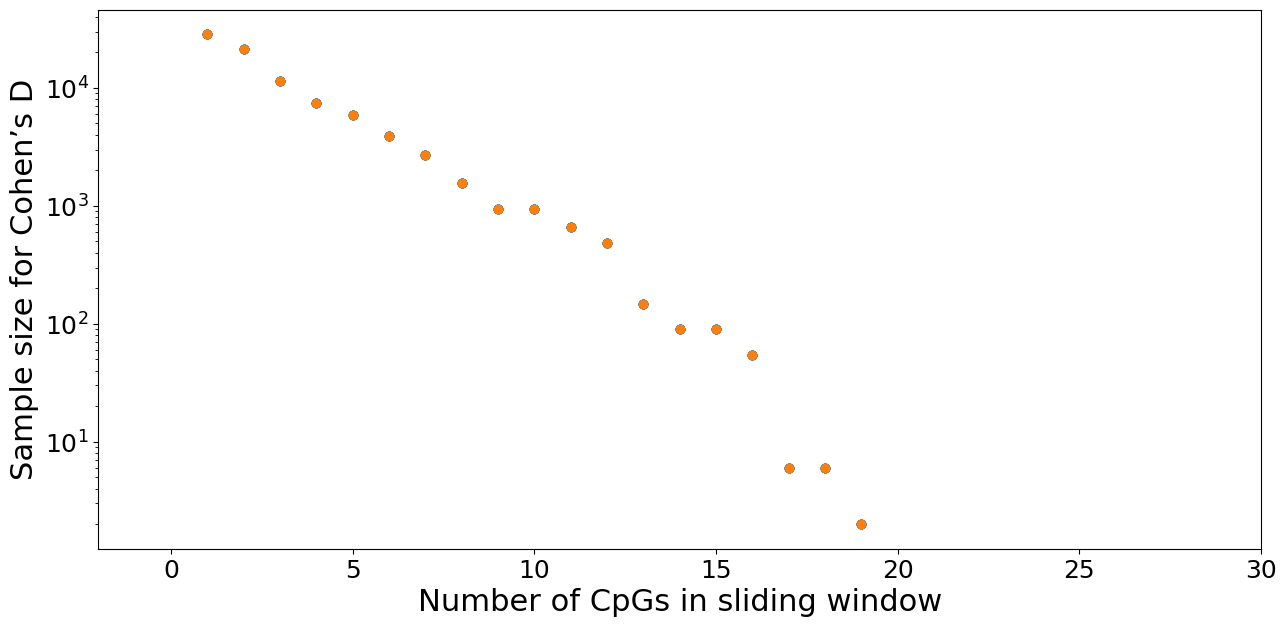

In [56]:
plt.figure(figsize=(15,7))
groups = df_NDR_pvalues.groupby(by='parameter')
for par, df_tmp in groups:
    plt.scatter(df_tmp['nbr_CpGs'], df_tmp['N_EXP'], label=par)

# plt.axhline(y=50)
plt.xlim(-2,30)
# plt.ylim((10**1,10**6))
# plt.legend()
plt.xlabel('Number of CpGs in sliding window', fontsize=22)
plt.ylabel('Sample size for Cohen’s D', fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yscale('log')

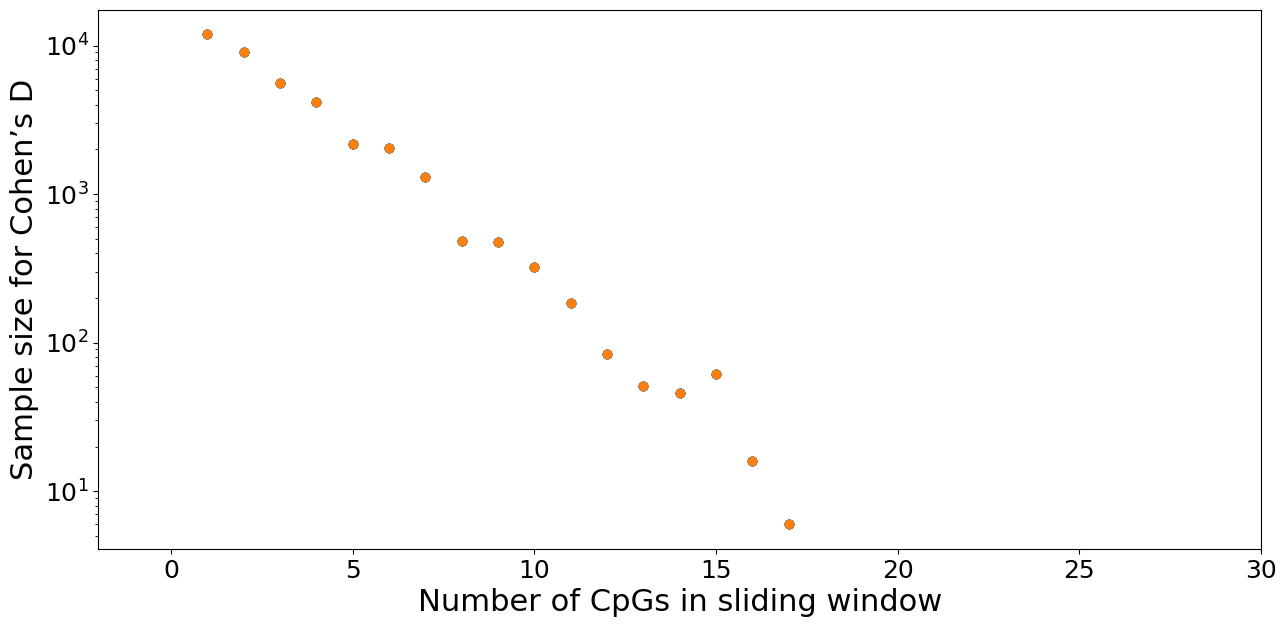

In [57]:
plt.figure(figsize=(15,7))
groups = df_NOR_pvalues.groupby(by='parameter')
for par, df_tmp in groups:
    plt.scatter(df_tmp['nbr_CpGs'], df_tmp['N_EXP'], label=par)
plt.xlim(-2,30)
# plt.legend()
plt.xlabel('Number of CpGs in sliding window', fontsize=22)
plt.ylabel('Sample size for Cohen’s D', fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yscale('log')

In [58]:
def plot_nbr_CpGs_cohensd(df_values, params):
    plt.figure(figsize=(15,7))
    ax = plt.subplot(1,1,1)
    
    nbr_CpGs_list = sorted(list(set(list(df_values["nbr_CpGs"]))))

    for par_name in params:
        
        df_values_tmp = df_values.loc[df_values["parameter"] == par_name]
        
        x_nbr_cpg_vals = list(df_values_tmp["nbr_CpGs"])
        y_cohens_d_vals = list(df_values_tmp["cohens_d"])
        
        if "m0" in par_name:
            c = "#117A65"
        if "m10" in par_name:
            c = "#45B39D"
        if "m20" in par_name:
            c = "#EB984E"
        if "c5" in par_name:
            m = "*"
            ms = 15
        if "c10" in par_name:
            m = "^"
            ms = 10
        if "c20" in par_name:
            m = "s"
            ms = 10
        if "c50" in par_name:
            m = "o"
            ms = 10
        
        
        plt.plot(x_nbr_cpg_vals, y_cohens_d_vals, linestyle="-", color=c, marker=m, markersize=ms, label=par_name)
    
    
    plt.axhline(y=0.2, linewidth=1, color = '#2C3E50',linestyle='--')
    plt.axhline(y=0.5, linewidth=1, color = '#2C3E50',linestyle='--')
    plt.axhline(y=0.8, linewidth=1, color = '#2C3E50',linestyle='--')
    
    e = 0.02
    ax.text(-1.8,0.2+e, "Small ES")
    ax.text(-1.8,0.5+e, "Medium ES")
    ax.text(-1.8,0.8+e, "Large ES")

    ax.set_ylabel("Cohen's D", fontsize=22)
    ax.set_xlabel("Number of CpGs in sliding window", fontsize=22)   

    plt.xlim(-2,30)
    plt.ylim(-5,5)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    legend = ax.legend(loc="lower left", ncol=4, frameon = 1, prop={'size':18})
    legend.get_frame().set_facecolor('white')

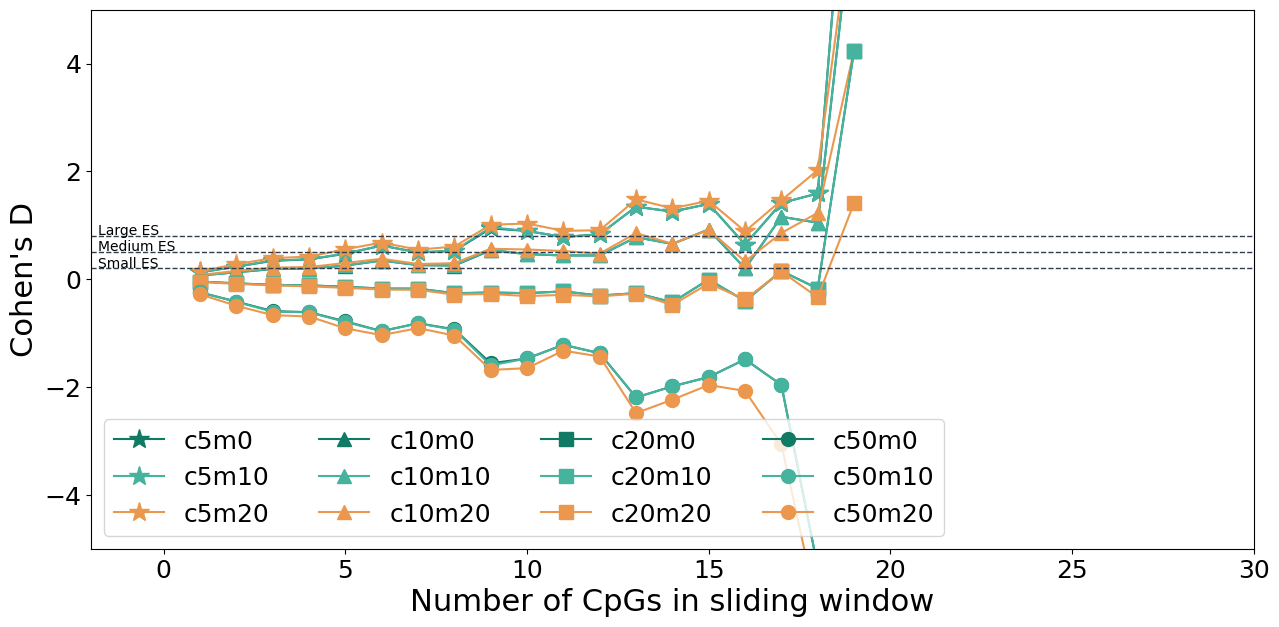

In [59]:
plot_nbr_CpGs_cohensd(df_NDR_pvalues, params)

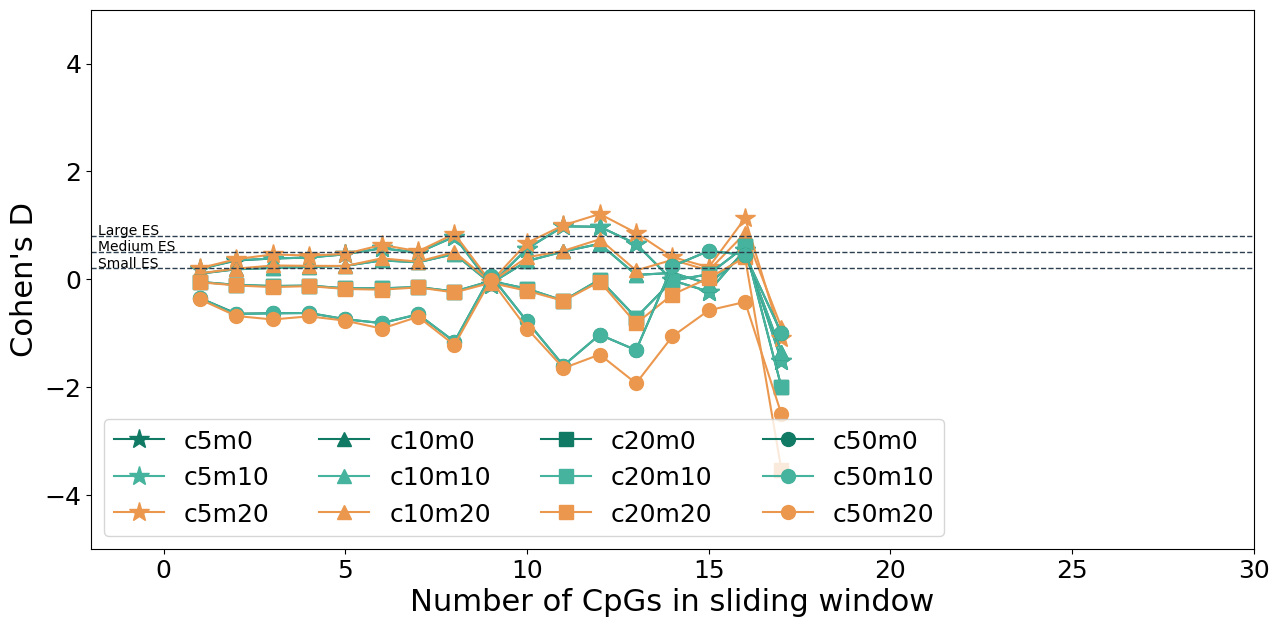

In [60]:
plot_nbr_CpGs_cohensd(df_NOR_pvalues, params)

In [ ]:
def plot_pvals_cohensd(df_values,params):
    
    plt.figure(figsize=(15,7))
    ax = plt.subplot(1,1,1)
    
    nbr_CpGs_list = sorted(list(set(list(df_values["nbr_CpGs"]))))
    
    for par_name in params:
        df_values_tmp = df_values.loc[df_values["parameter"] == par_name]
        
        x_nbr_cpg_vals = list(df_values_tmp["nbr_CpGs"])
        y_pvals_vals = list(df_values_tmp["pval_ranksums"])
        
        y_pvals_log = [-np.log10(p_val) if p_val != 0.0 else 310 for p_val in y_pvals_vals]
        # print(min([p_val for p_val in y_pvals_vals]))
        # y_pvals_log = [-np.log10(p_val) for p_val in y_pvals_vals]
        
        if "m0" in par_name:
            c = "#117A65"
        if "m10" in par_name:
            c = "#45B39D"
        if "m20" in par_name:
            c = "#EB984E"
        if "c5" in par_name:
            m = "*"
            ms = 15
        if "c10" in par_name:
            m = "^"
            ms = 10
        if "c20" in par_name:
            m = "s"
            ms = 10
        if "c50" in par_name:
            m = "o"
            ms = 10
        
        
        plt.plot(x_nbr_cpg_vals,y_pvals_log,linestyle="-",color=c,marker=m,markersize=ms,label=par_name)
    
    
    #plt.axhline(y=-np.log10(0.05), linewidth=1, color = '#5D6D7E',linestyle='-')
    #plt.axhline(y=-np.log10(0.01), linewidth=1, color = '#515A5A',linestyle='-')

    ax.set_ylabel("-log10(P-value)", fontsize=22)
    ax.set_xlabel("Number of CpGs in sliding window", fontsize=22)   

    plt.xlim(-2, 30)
    plt.ylim(0, 450)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    legend = ax.legend(loc="upper right",ncol=4,frameon = 1,prop={'size':18})
    legend.get_frame().set_facecolor('white')

In [ ]:
plot_pvals_cohensd(df_NDR_pvalues, params)

In [ ]:
plot_pvals_cohensd(df_NOR_pvalues, params)

#### Cohen's D Calculation Table

In [14]:
import scipy
from scipy import stats

def calculate_cohens_d(list_EXP,list_RAND):
    mEXP = np.mean(list_EXP)
    sdEXP = np.std(list_EXP)
    
    mRAND = np.mean(list_RAND)
    sdRAND = np.std(list_RAND)
    
    denom = np.sqrt(float(sdEXP**2 + sdRAND**2)/2.0)
    cohens_d = float(mEXP-mRAND)/float(denom + 1e-6)
    
    return cohens_d

def make_df_cohens_d(df_scores_EXP, df_scores_RAND, params):
    column_names = ["parameter", "N_EXP", "N_RAND", "mean_EXP", "median_EXP", "std_EXP", "mean_RAND",
                    "median_RAND", "std_RAND", "cohens_d", "is_normal_EXP", "is_normal_RAND", "pval_ttest",
                    "t_stat", "pval_ranksums", "pval_ks_2samp"]
    info_dict = dict()
    for col in column_names:
        info_dict[col] = []
    
    df_scores_EXP_tmp = df_scores_EXP.loc[df_scores_EXP['nbr_CpGs'].between(10,20)]
    df_scores_RAND_tmp = df_scores_RAND.loc[df_scores_RAND['nbr_CpGs'].between(10,20)]
                    
    for p in range(len(params)):
        par_name = params[p]
        EXP_scores = list(df_scores_EXP_tmp[par_name])
        RAND_scores = list(df_scores_RAND_tmp[par_name])
        
        # info_dict["nbr_CpGs"].append(nbr_CpGs)
        info_dict["parameter"].append(par_name)
        
        info_dict["N_EXP"].append(len(EXP_scores))
        info_dict["N_RAND"].append(len(RAND_scores))
        
        info_dict["mean_EXP"].append(np.mean(EXP_scores))
        info_dict["median_EXP"].append(np.median(EXP_scores))
        info_dict["std_EXP"].append(np.std(EXP_scores))
        
        info_dict["mean_RAND"].append(np.mean(RAND_scores))
        info_dict["median_RAND"].append(np.median(RAND_scores))
        info_dict["std_RAND"].append(np.std(RAND_scores))
        
        #EFFECT SIZE
        cohens_d = calculate_cohens_d(EXP_scores, RAND_scores)
        info_dict["cohens_d"].append(cohens_d)
        
        #STAT TESTS
        #is normal distributed? This function tests the null hypothesis that a sample comes from a normal distribution. If small -> ost likely not normal dustributed
        pval_normal_EXP = stats.normaltest(EXP_scores)[1] if len(EXP_scores) >= 8 else -1
        pval_normal_RAND = stats.normaltest(RAND_scores)[1] if len(EXP_scores) >= 8 else -1
        
        #students t
        ttest_res = stats.ttest_ind(EXP_scores,RAND_scores,equal_var = False)
        t_stat = ttest_res[0]
        p_val_ttest = float(ttest_res[1])/2.0
        
        #ranksums, kstest
        ranksums = scipy.stats.ranksums(EXP_scores,RAND_scores)[1]
        ks_2samp = scipy.stats.ks_2samp(EXP_scores,RAND_scores)[1]

        info_dict["is_normal_EXP"].append(pval_normal_EXP)
        info_dict["is_normal_RAND"].append(pval_normal_RAND)
        info_dict["pval_ttest"].append(p_val_ttest)
        info_dict["t_stat"].append(t_stat)
        info_dict["pval_ranksums"].append(ranksums)
        info_dict["pval_ks_2samp"].append(ks_2samp)
            
    #Built dataframe
    df = pd.DataFrame(0, index = np.arange(len(info_dict["parameter"])),columns = column_names)
    for feat in column_names:
        df[feat] = info_dict[feat]

    return df

In [15]:
# region = 'promoter'
# region = 'intron.1.start'
# region = 'intron.1.end'
# region = 'intron.2.start'

In [16]:
# df_NDR_score_exp = pd.read_csv(sliding_path / f'{region}.df_NDR_score_exp.csv')
# df_NDR_score_random = pd.read_csv(sliding_path / f'{region}.df_NDR_score_random.csv')
# df_NOR_score_exp = pd.read_csv(sliding_path / f'{region}.df_NOR_score_exp.csv')
# df_NOR_score_random = pd.read_csv(sliding_path / f'{region}.df_NOR_score_random.csv')

In [17]:
# df_NDR_pvalues = make_df_cohens_d(df_NDR_score_exp, df_NDR_score_random, params)

In [18]:
# df_NOR_pvalues = make_df_cohens_d(df_NOR_score_exp, df_NOR_score_random, params)

In [19]:
# df_NDR_pvalues

In [20]:
# df_NOR_pvalues

In [26]:
expression = False
regions = ['promoter', 'intron.1.start', 'intron.1.end', 'intron.2.start']
labels = ['promoter', 'start of 1st intron', 'end of 1st intron', 'start of 2nd intron']
table = {}
for label, region in zip(labels, regions):
    print(region, expression)
    df_NDR_score_exp = pd.read_csv(sliding_path / f'{region}.df_NDR_score_exp.csv')
    df_NDR_score_random = pd.read_csv(sliding_path / f'{region}.df_NDR_score_random.csv')
    df_NOR_score_exp = pd.read_csv(sliding_path / f'{region}.df_NOR_score_exp.csv')
    df_NOR_score_random = pd.read_csv(sliding_path / f'{region}.df_NOR_score_random.csv')

    if expression:
        print(f"NDR Exp unique transcripts: {df_NDR_score_exp['refid'].unique().shape}")
        df_NDR_score_exp = df_NDR_score_exp[df_NDR_score_exp['refid'].isin(transcript_expressed)]
        print(f"NDR Exp Expressed unique transcripts: {df_NDR_score_exp['refid'].unique().shape}")

        print(f"NDR Rand unique transcripts: {df_NDR_score_random['refid'].unique().shape}")
        df_NDR_score_random = df_NDR_score_random[df_NDR_score_random['refid'].isin(transcript_expressed)]
        print(f"NDR Rand Expressed unique transcripts: {df_NDR_score_random['refid'].unique().shape}")

        print(f"NOR Exp unique transcripts: {df_NOR_score_exp['refid'].unique().shape}")
        df_NOR_score_exp = df_NOR_score_exp[df_NOR_score_exp['refid'].isin(transcript_expressed)]
        print(f"NOR Exp Expressed unique transcripts: {df_NOR_score_exp['refid'].unique().shape}")

        print(f"NOR Rand unique transcripts: {df_NOR_score_random['refid'].unique().shape}")
        df_NOR_score_random = df_NOR_score_random[df_NOR_score_random['refid'].isin(transcript_expressed)]
        print(f"NOR Rand Expressed unique transcripts: {df_NOR_score_random['refid'].unique().shape}")
    else:
        print(f"NDR Exp unique transcripts: {df_NDR_score_exp['refid'].unique().shape}")
        df_NDR_score_exp = df_NDR_score_exp[df_NDR_score_exp['refid'].isin(transcript_not_expressed)]
        print(f"NDR Exp Not Expressed unique transcripts: {df_NDR_score_exp['refid'].unique().shape}")

        print(f"NDR Rand unique transcripts: {df_NDR_score_random['refid'].unique().shape}")
        df_NDR_score_random = df_NDR_score_random[df_NDR_score_random['refid'].isin(transcript_not_expressed)]
        print(f"NDR Rand Not Expressed unique transcripts: {df_NDR_score_random['refid'].unique().shape}")

        print(f"NOR Exp unique transcripts: {df_NOR_score_exp['refid'].unique().shape}")
        df_NOR_score_exp = df_NOR_score_exp[df_NOR_score_exp['refid'].isin(transcript_not_expressed)]
        print(f"NOR Exp Not Expressed unique transcripts: {df_NOR_score_exp['refid'].unique().shape}")

        print(f"NOR Rand unique transcripts: {df_NOR_score_random['refid'].unique().shape}")
        df_NOR_score_random = df_NOR_score_random[df_NOR_score_random['refid'].isin(transcript_not_expressed)]
        print(f"NOR Rand Not Expressed unique transcripts: {df_NOR_score_random['refid'].unique().shape}")

    df_NDR_pvalues = make_df_cohens_d(df_NDR_score_exp, df_NDR_score_random, params)
    df_NOR_pvalues = make_df_cohens_d(df_NOR_score_exp, df_NOR_score_random, params)

    assert df_NDR_pvalues.shape[0] == df_NOR_pvalues.shape[0]
    assert df_NDR_pvalues['parameter'].to_list() == df_NOR_pvalues['parameter'].to_list()

    table[label] = {
        'Parameter': df_NDR_pvalues['parameter'].to_list(),
        'HNDRs': df_NOR_pvalues['cohens_d'].to_list(),
        'LNDRs': df_NDR_pvalues['cohens_d'].to_list()
    }

promoter False
NDR Exp unique transcripts: (25164,)
NDR Exp Not Expressed unique transcripts: (1557,)
NDR Rand unique transcripts: (25164,)
NDR Rand Not Expressed unique transcripts: (1557,)
NOR Exp unique transcripts: (3886,)
NOR Exp Not Expressed unique transcripts: (200,)
NOR Rand unique transcripts: (3886,)
NOR Rand Not Expressed unique transcripts: (200,)
intron.1.start False
NDR Exp unique transcripts: (17190,)
NDR Exp Not Expressed unique transcripts: (1112,)
NDR Rand unique transcripts: (17190,)
NDR Rand Not Expressed unique transcripts: (1112,)
NOR Exp unique transcripts: (2377,)
NOR Exp Not Expressed unique transcripts: (125,)
NOR Rand unique transcripts: (2377,)
NOR Rand Not Expressed unique transcripts: (125,)
intron.1.end False
NDR Exp unique transcripts: (10806,)
NDR Exp Not Expressed unique transcripts: (819,)
NDR Rand unique transcripts: (10806,)
NDR Rand Not Expressed unique transcripts: (819,)
NOR Exp unique transcripts: (1263,)
NOR Exp Not Expressed unique transcript

In [27]:
df_table = pd.DataFrame(table).T.explode(['Parameter', 'LNDRs', 'HNDRs'])

In [28]:
df_table

,Parameter,HNDRs,LNDRs
promoter,c5m0,0.757662,0.408662
promoter,c5m10,0.757662,0.404583
promoter,c5m20,0.846692,0.448963
promoter,c10m0,0.422802,0.229948
promoter,c10m10,0.422802,0.227438
promoter,c10m20,0.467306,0.251905
promoter,c20m0,-0.24481,-0.126115
promoter,c20m10,-0.24481,-0.124289
promoter,c20m20,-0.272242,-0.133721
promoter,c50m0,-1.222915,-0.671006


In [ ]:
print(df_table.to_latex(float_format="{:.2f}".format))

In [29]:
df_table[df_table['Parameter'].isin(['c5m0', 'c5m10', 'c5m20'])]

,Parameter,HNDRs,LNDRs
promoter,c5m0,0.757662,0.408662
promoter,c5m10,0.757662,0.404583
promoter,c5m20,0.846692,0.448963
start of 1st intron,c5m0,0.680916,0.693665
start of 1st intron,c5m10,0.680916,0.693631
start of 1st intron,c5m20,0.728851,0.769085
end of 1st intron,c5m0,0.651946,0.871079
end of 1st intron,c5m10,0.630745,0.871663
end of 1st intron,c5m20,0.656968,1.02537
start of 2nd intron,c5m0,0.597151,0.877022


In [30]:
print(df_table[df_table['Parameter'].isin(['c5m0', 'c5m10', 'c5m20'])].to_latex(float_format="{:.2f}".format))

\begin{tabular}{llll}
\toprule
{} & Parameter & HNDRs & LNDRs \\
\midrule
promoter            &      c5m0 &  0.76 &  0.41 \\
promoter            &     c5m10 &  0.76 &  0.40 \\
promoter            &     c5m20 &  0.85 &  0.45 \\
start of 1st intron &      c5m0 &  0.68 &  0.69 \\
start of 1st intron &     c5m10 &  0.68 &  0.69 \\
start of 1st intron &     c5m20 &  0.73 &  0.77 \\
end of 1st intron   &      c5m0 &  0.65 &  0.87 \\
end of 1st intron   &     c5m10 &  0.63 &  0.87 \\
end of 1st intron   &     c5m20 &  0.66 &  1.03 \\
start of 2nd intron &      c5m0 &  0.60 &  0.88 \\
start of 2nd intron &     c5m10 &  0.60 &  0.88 \\
start of 2nd intron &     c5m20 &  0.75 &  0.99 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1491800/2379574417.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_table[df_table['Parameter'].isin(['c5m0', 'c5m10', 'c5m20'])].to_latex(float_format="{:.2f}".format))


#### Histograms

In [ ]:
region = 'promoter'
# region = 'intron.1.start'
# region = 'intron.1.end'
# region = 'intron.2.start'

In [ ]:
df_NDR_score_exp = pd.read_csv(sliding_path / f'{region}.df_NDR_score_exp.csv')
df_NDR_score_random = pd.read_csv(sliding_path / f'{region}.df_NDR_score_random.csv')
df_NOR_score_exp = pd.read_csv(sliding_path / f'{region}.df_NOR_score_exp.csv')
df_NOR_score_random = pd.read_csv(sliding_path / f'{region}.df_NOR_score_random.csv')

In [ ]:
df_NDR_score_exp.columns

In [ ]:
fig, axs = plt.subplots(3, 4, figsize=(20,12), layout='constrained')
order = ['c5m0', 'c10m0', 'c20m0', 'c50m0', 'c5m10', 'c10m10', 'c20m10', 'c50m10', 'c5m20', 'c10m20', 'c20m20', 'c50m20']

for ax, thresh in zip(axs.flatten(), order):
    ax.hist(df_NDR_score_random.loc[df_NDR_score_random['nbr_CpGs'].between(10,20), thresh], density=True, alpha=0.5, bins=np.linspace(0,1,20), label='random')
    ax.hist(df_NDR_score_exp.loc[df_NDR_score_exp['nbr_CpGs'].between(10,20), thresh], density=True, alpha=0.3, bins=np.linspace(0,1,20), label='experimental')
    ax.set_title(thresh, fontsize=20)
    ax.set_xlabel('match-score', fontsize=16)
    ax.set_ylabel('density', fontsize=16)
    ax.legend(fontsize=12)

In [ ]:
fig, axs = plt.subplots(3, 4, figsize=(20,12), layout='constrained')
order = ['c5m0', 'c10m0', 'c20m0', 'c50m0', 'c5m10', 'c10m10', 'c20m10', 'c50m10', 'c5m20', 'c10m20', 'c20m20', 'c50m20']

for ax, thresh in zip(axs.flatten(), order):
    ax.hist(df_NOR_score_random.loc[df_NOR_score_random['nbr_CpGs'].between(10,20), thresh], density=True, alpha=0.5, bins=np.linspace(0,1,20), label='random')
    ax.hist(df_NOR_score_exp.loc[df_NOR_score_exp['nbr_CpGs'].between(10,20), thresh], density=True, alpha=0.3, bins=np.linspace(0,1,20), label='experimental')
    ax.set_title(thresh, fontsize=20)
    ax.set_xlabel('match-score', fontsize=16)
    ax.set_ylabel('density', fontsize=16)
    ax.legend(fontsize=12)